In [3]:
import warnings
import numpy as np
import pandas as pd
from math import isnan, sqrt
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

In [4]:
np.random.RandomState(42)
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Data prep

In [5]:
hiae = pd.read_csv("data/hiae.csv")
hmvsc = pd.read_csv("data/hmvsc.csv")

In [6]:
# Valid variable thresholds
thresholds = {
    'highest_respiratory_rate1h': [10, 40],
    'highest_temperature1h': [30, 42],
    'highest_heart_rate1h': [20, 220],
    'lowest_mean_arterial_pressure1h': [20, 150],
    'lowest_diastolic_blood_pressure1h': [20, 200],
    'lowest_systolic_blood_pressure1h': [30, 250],
    'bmi': [10, 70]
}

In [7]:
# Normal values for each continuous feature
normal = {
    'highest_respiratory_rate1h': 16,
    'highest_temperature1h': 37,
    'highest_heart_rate1h': 80,
    'lowest_mean_arterial_pressure1h': 90,
    'lowest_diastolic_blood_pressure1h': 80,
    'lowest_systolic_blood_pressure1h': 120,
    'lowest_glasgow_coma_scale1h': 15,
    'lengthhospitalstaypriorunitadmission': 0
}

In [8]:
# Function to remove invalid thresholds
def remove_invalid(df, thresholds):
    for c in thresholds:
        df.loc[(df[c] < thresholds[c][0]) | (df[c] > thresholds[c][1]), c] = np.nan

In [9]:
# Group glasgow
def group_gcs(gcs):
    if isnan(gcs):
        return np.nan
    
    gcs = int(gcs)
    if gcs < 15:
        return 1
    elif gcs == 15:
        return 2

In [10]:
# Group admission sources
def group_adm_src(df):
     df['admissionsourcename'].replace({
         'Enfermaria / quarto': 'floor',
         'Centro Cirúrgico': 'operating room',
         'Sala de hemodinâmica': 'operating room',
         'Emergência': 'emergency room',
         'Home-care': 'emergency room', 
         'Transferência de outro hospital/instituição': 'other sources',
         'Outra UTI/UCI do seu hospital': 'other icu',
         'Unidade Semi-intensiva': 'other sources',
         'Outra - Não especificada': 'other sources'
     }, inplace=True)

In [11]:
# Remove invalid thresholds
remove_invalid(hiae, thresholds)
remove_invalid(hmvsc, thresholds)

# Group gcs
hiae['glasgow'] = hiae['lowest_glasgow_coma_scale1h'].apply(group_gcs)
hmvsc['glasgow'] = hmvsc['lowest_glasgow_coma_scale1h'].apply(group_gcs)

# Group admission source
group_adm_src(hiae)
group_adm_src(hmvsc)

In [12]:
class Imputer:
    """
    Imputes mode for each categorical column and pre-defined normal values otherwise.
    """
    def __init__(self, normal, c_cols):
        self.normal = normal
        self.c_cols = c_cols

    def fit(self, X, y=None):
        self.modes = [(c, X[c].dropna().mode()[0]) for c in self.c_cols]
        return self

    def transform(self, X):
        output = X.copy()
        for c, v in self.normal.items():
            output[c].fillna(v, inplace=True)
        for c, v in self.modes:
            output[c].fillna(v, inplace=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [13]:
# Lists of variable types
target = "hospitalexpireflag"

# Pre-icu
demographic = ["genders", "admissionsourcename", "admissiontypename", "chronic_health_status_name",
               "age", "lengthhospitalstaypriorunitadmission", "bmi_group"]

# Lab results
physiological = ["lowest_systolic_blood_pressure1h", "lowest_diastolic_blood_pressure1h",
                 "lowest_mean_arterial_pressure1h", "highest_heart_rate1h", "highest_respiratory_rate1h",
                 "highest_temperature1h"]

glasgow = ["glasgow"]
                 
c_cols_og = ["genders", "admissionsourcename", "admissiontypename", "chronic_health_status_name", 
          "glasgow", "bmi_group"]

n_cols_og = ["age", "lowest_systolic_blood_pressure1h", "lowest_glasgow_coma_scale1h",
          "lowest_diastolic_blood_pressure1h","lowest_mean_arterial_pressure1h", "highest_heart_rate1h", 
          "highest_respiratory_rate1h", "highest_temperature1h", "lengthhospitalstaypriorunitadmission"]

In [14]:
def columns2block(block):
    if block == 1:
        columns = physiological
    elif block == 2:
        columns = physiological + glasgow
    elif block == 3:
        columns = demographic
    elif block == 4:
        columns = physiological + demographic
    elif block == 5:
        columns = physiological + demographic + glasgow
    return columns

In [15]:
def prep_data(hiae, hmvsc, columns, target, model='logr'):
    # Seperate x and y values
    X_hiae = hiae[columns].copy()
    X_hmvsc = hmvsc[columns].copy()
    
    y_hiae = hiae[target].copy()
    y_hmvsc = hmvsc[target].copy()    
    
    # Create null flag column
    if model != 'xgb':
        for c in X_hiae.columns:
            X_hiae[c+"_null"] = X_hiae[c].isna().astype(int)
            X_hmvsc[c+"_null"] = X_hmvsc[c].isna().astype(int)

    # Filtering the columns according to each block
    c_cols = [c for c in c_cols_og if c in X_hiae.columns]
    n_cols = [n for n in n_cols_og if n in X_hiae.columns]    
    
    # Impute "missing" for missing categorical values
    if model == 'xgb':
        for c in c_cols:
            if X_hiae[c].dtype in [int,float]: missing = -1
            else: missing = "missing"
            X_hiae[c] = X_hiae[c].fillna(missing)
            X_hmvsc[c] = X_hmvsc[c].fillna(missing)
        
    # Get unique values for categorical features,
    c_vals = [X_hiae.append(X_hmvsc).dropna()[c].unique() for c in c_cols]
    c_vals = [sorted(cv) for cv in c_vals]
    
    # Normal values filtered for each block
    filtered_normal = {}
    for key in normal.keys():
        if key in n_cols: filtered_normal[key] = normal[key]
        
    return X_hiae, y_hiae, X_hmvsc, y_hmvsc, filtered_normal, c_cols, n_cols, c_vals

### Helper Functions To Run The Models

In [16]:
def smr_score(y_true, y_pred):
    return sum(y_true)/sum(y_pred)

In [17]:
def plot_calib_curve(y_true, y_pred, ax = None, n_bins = 10, with_histogram=False, width=0.1, **kwargs):
    if type(y_true) is list:
        y_true = np.asarray(y_true)
    if type(y_pred) is list:
        y_pred = np.asarray(y_pred)
        
    # Metrics Logit
    if ax is None:
        ax=plt.gca()
        
    # calculate SMR
    smr = smr_score(y_true, y_pred)
    smr_ci = ci(smr_score, y_true, y_pred)
    
    # calculate AUROC
    auc_value = roc_auc_score(y_true, y_pred)
    auc_ci = ci(roc_auc_score, y_true, y_pred)
    
    # add AUROC to legend
    if 'label' not in kwargs:
        kwargs['label'] = ''
    
    xi = np.linspace(0, 1, n_bins+1)
    
    expected  = np.ones(n_bins)*np.nan
    observed = np.ones(n_bins)*np.nan
    N = np.zeros(n_bins)
    for i in range(len(xi)-1):
        idx = (y_pred > xi[i]) & (y_pred <= xi[i+1])
        if np.any(idx):
            expected[i] = np.sum(y_pred[idx])
            observed[i] = np.sum(y_true[idx])
            N[i] = np.sum(idx)
    
    # calibration curve
    p = ax.plot(expected/N, observed/N, **kwargs)
    
    if with_histogram:
        # add transparent histogram
        c = p[0].get_color()
        ax.bar(expected/N, N/np.sum(N), width=width, alpha=0.5, facecolor=c)
        
    print(kwargs['label'] + "\tAUC - {:0.2f} ({:0.2f} - {:0.2f} 95% CI)".format(auc_value, auc_ci[0], auc_ci[1]))
    print(kwargs['label'] + "\tSMR - {:0.2f} ({:0.2f} - {:0.2f} 95% CI)".format(smr, smr_ci[0], smr_ci[1]))

In [18]:
def ci(metric, y_true, y_pred, confidence=0.95, samples=2000):
    '''Confidence Interval calculator'''
    
    scores = []
    for i in range(samples):
        indices = np.random.randint(0, len(y_pred) - 1, len(y_pred))
        scores.append(metric(y_true[indices], y_pred[indices]))
    scores = np.sort(scores)
    
    n = len(scores)
    lower = int( (1 - confidence) / 2 * n )
    upper = int( (1 + confidence) / 2 * n )
    
    return (scores[lower], scores[upper])

## TropICS

#### HMVSC

In [19]:
tropics_hmvsc = hmvsc.copy()
tropics_hmvsc = Imputer(normal, c_cols_og).fit_transform(tropics_hmvsc)
tropics_hmvsc.highest_respiratory_rate1h = np.log(tropics_hmvsc.highest_respiratory_rate1h)
tropics_hmvsc.emergency_surgery = (tropics_hmvsc.admissiontypename 
                             == "Cirurgia de urgência / emergência").astype(int)

In [20]:
tropics_hmvsc.tropics = 0.73 * tropics_hmvsc.emergency_surgery \
            +  0.064 * tropics_hmvsc.highest_respiratory_rate1h \
            + -0.128 * tropics_hmvsc.lowest_glasgow_coma_scale1h

In [21]:
print("------Hospital Mortality------")
print(round(roc_auc_score(tropics_hmvsc[target], tropics_hmvsc.tropics),2))
tropics_hosp = ci(roc_auc_score, tropics_hmvsc[target], tropics_hmvsc.tropics)
print(round(tropics_hosp[0],2), round(tropics_hosp[1],2))

print("------ICU Mortality------")
print(round(roc_auc_score(tropics_hmvsc.unitdischargecode, tropics_hmvsc.tropics),2))
tropics_icu = ci(roc_auc_score, tropics_hmvsc.unitdischargecode, tropics_hmvsc.tropics)
print(round(tropics_icu[0],2), round(tropics_icu[1],2))

------Hospital Mortality------
0.59
0.55 0.62
------ICU Mortality------
0.58
0.54 0.63


#### HIAE

In [22]:
tropics_hiae = hiae.copy()
tropics_hiae.unitdischargecode.fillna(0, inplace=True)
tropics_hiae = Imputer(normal, c_cols_og).fit_transform(tropics_hiae)
tropics_hiae.highest_respiratory_rate1h = np.log(tropics_hiae.highest_respiratory_rate1h)
tropics_hiae.emergency_surgery = (tropics_hiae.admissiontypename 
                             == "Cirurgia de urgência / emergência").astype(int)

In [23]:
tropics_hiae.tropics = 0.73 * tropics_hiae.emergency_surgery \
            +  0.064 * tropics_hiae.highest_respiratory_rate1h \
            + -0.128 * tropics_hiae.lowest_glasgow_coma_scale1h

In [24]:
print("------Hospital Mortality------")
print(round(roc_auc_score(tropics_hiae[target], tropics_hiae.tropics),2))
tropics_hosp = ci(roc_auc_score, tropics_hiae[target], tropics_hiae.tropics)
print(round(tropics_hosp[0],2), round(tropics_hosp[1],2))

print("------ICU Mortality------")
print(round(roc_auc_score(tropics_hiae.unitdischargecode, tropics_hiae.tropics),2))
tropics_icu = ci(roc_auc_score, tropics_hiae.unitdischargecode, tropics_hiae.tropics)
print(round(tropics_icu[0],2), round(tropics_icu[1],2))

------Hospital Mortality------
0.64
0.62 0.67
------ICU Mortality------
0.66
0.62 0.69


## R-MPM

#### HMVSC

In [25]:
rmpm_hmvsc = hmvsc.copy()
rmpm_hmvsc = Imputer(normal, c_cols_og).fit_transform(rmpm_hmvsc)
rmpm_hmvsc.infection = (rmpm_hmvsc.admissionreasonname == "Infecção/Sepse").astype(int)
rmpm_hmvsc.hiposhock = ((rmpm_hmvsc.admissionreasonname == "Choque (exceto sepse)") | 
                        (rmpm_hmvsc.admissionmaindiagnosisname == "Hipotensão")).astype(int)

In [26]:
rmpm_hmvsc.rmpm = np.log(1.02) * round(rmpm_hmvsc.age, -1) \
                + np.log(3.14) * rmpm_hmvsc.infection \
                + np.log(2.54) * rmpm_hmvsc.hiposhock \
                + np.log(0.79) * rmpm_hmvsc.lowest_glasgow_coma_scale1h \
                + np.log(1.02) * round(rmpm_hmvsc.highest_heart_rate1h, -1)

In [27]:
print(round(roc_auc_score(rmpm_hmvsc[target], rmpm_hmvsc.rmpm),2))
rmpm_hosp = ci(roc_auc_score, rmpm_hmvsc[target], rmpm_hmvsc.rmpm)
print(round(rmpm_hosp[0],2), round(rmpm_hosp[1],2))

0.77
0.73 0.79


#### HIAE 

In [28]:
rmpm_hiae = hiae.copy()
rmpm_hiae = Imputer(normal, c_cols_og).fit_transform(rmpm_hiae)
rmpm_hiae.infection = (rmpm_hiae.admissionreasonname == "Infecção/Sepse").astype(int)
rmpm_hiae.hiposhock = ((rmpm_hiae.admissionreasonname == "Choque (exceto sepse)") | 
                       (rmpm_hiae.admissionmaindiagnosisname == "Hipotensão")).astype(int)

In [29]:
rmpm_hiae.rmpm = np.log(1.02) * round(rmpm_hiae.age, -1) \
            + np.log(3.14) * rmpm_hiae.infection \
            + np.log(2.54) * rmpm_hiae.hiposhock \
            + np.log(0.79) * rmpm_hiae.lowest_glasgow_coma_scale1h \
            + np.log(1.02) * round(rmpm_hiae.highest_heart_rate1h, -1)

In [30]:
print(round(roc_auc_score(rmpm_hiae[target], rmpm_hiae.rmpm),2))
rmpm_hosp = ci(roc_auc_score, rmpm_hiae[target], rmpm_hiae.rmpm)
print(round(rmpm_hosp[0],2), round(rmpm_hosp[1],2))

0.75
0.73 0.77


## SAPS3

#### HMVSC

In [31]:
print(round(roc_auc_score(hmvsc[target], hmvsc.saps_prob),2))
saps_hosp = ci(roc_auc_score, hmvsc[target], hmvsc.saps_prob)
print(round(saps_hosp[0],2), round(saps_hosp[1],2))

0.82
0.79 0.84


#### HIAE

In [32]:
print(round(roc_auc_score(hiae[target], hiae.saps_prob),2))
saps_hosp = ci(roc_auc_score, hiae[target], hiae.saps_prob)
print(round(saps_hosp[0],2), round(saps_hosp[1],2))

0.84
0.82 0.86


## Logit trained in HIAE data

HIAE	AUC - 0.66 (0.63 - 0.68 95% CI)
HIAE	SMR - 1.00 (0.91 - 1.08 95% CI)
HMVSC	AUC - 0.65 (0.62 - 0.69 95% CI)
HMVSC	SMR - 2.15 (1.94 - 2.36 95% CI)


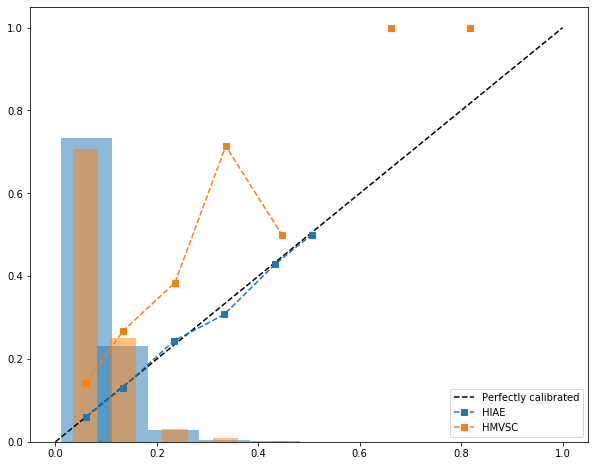

HIAE	AUC - 0.74 (0.72 - 0.76 95% CI)
HIAE	SMR - 1.00 (0.92 - 1.08 95% CI)
HMVSC	AUC - 0.78 (0.76 - 0.81 95% CI)
HMVSC	SMR - 2.08 (1.89 - 2.28 95% CI)


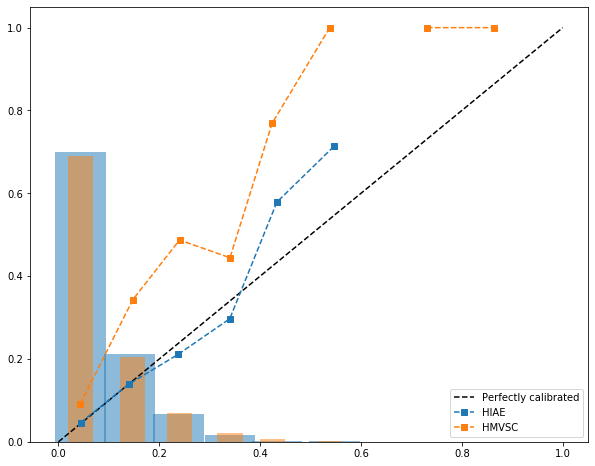

HIAE	AUC - 0.77 (0.75 - 0.79 95% CI)
HIAE	SMR - 1.00 (0.92 - 1.07 95% CI)
HMVSC	AUC - 0.76 (0.73 - 0.79 95% CI)
HMVSC	SMR - 2.32 (2.10 - 2.52 95% CI)


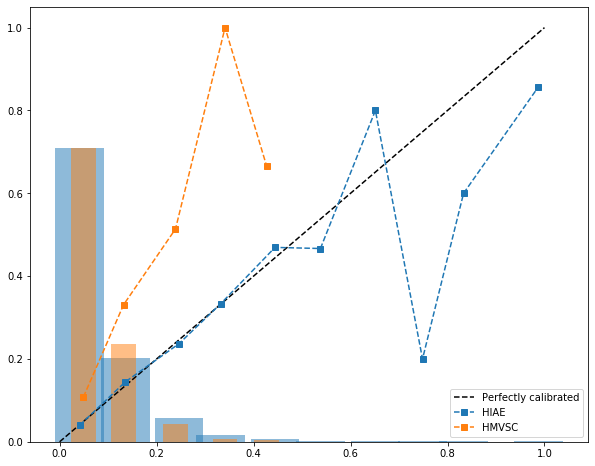

HIAE	AUC - 0.80 (0.78 - 0.82 95% CI)
HIAE	SMR - 1.00 (0.92 - 1.08 95% CI)
HMVSC	AUC - 0.79 (0.76 - 0.81 95% CI)
HMVSC	SMR - 2.17 (1.98 - 2.37 95% CI)


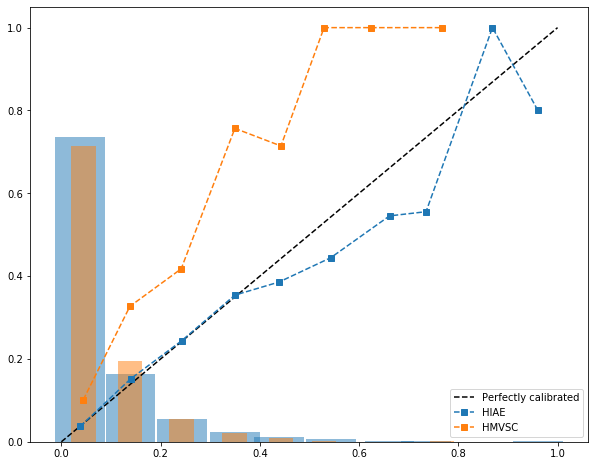

HIAE	AUC - 0.83 (0.81 - 0.84 95% CI)
HIAE	SMR - 1.00 (0.92 - 1.07 95% CI)
HMVSC	AUC - 0.84 (0.81 - 0.86 95% CI)
HMVSC	SMR - 1.93 (1.77 - 2.10 95% CI)


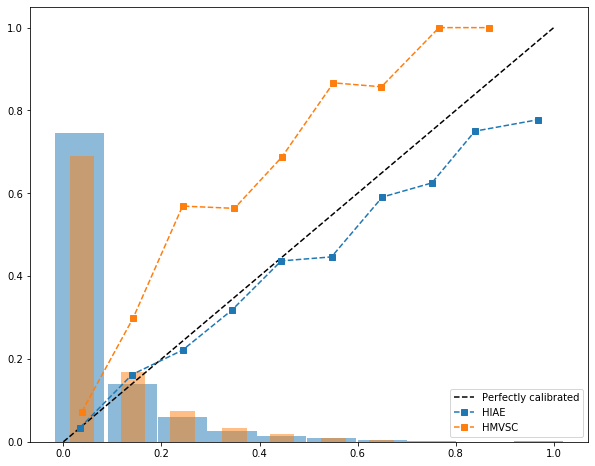

In [33]:
'''Run the model on each of the four blocks'''
for block in range(1,6):
    # prepare data
    X_hiae, y_hiae, X_hmvsc, y_hmvsc, filtered_normal, c_cols, n_cols, c_vals = prep_data(
        hiae.copy(), hmvsc.copy(), columns2block(block), target, model='logr')
    
    # Model
    logr = LogisticRegression(solver='liblinear', penalty='l1')

    # Create pipeline
    pipe = Pipeline([
        ("imputer", Imputer(filtered_normal, c_cols)),
        ("transformer", ColumnTransformer([
            ("ohe", OneHotEncoder(categories=c_vals), c_cols),
            ("scaler", StandardScaler(), n_cols)
        ], remainder="passthrough")),
        ("model", logr)
    ])
    
    #== train model on hiae
    model = pipe.fit(X_hiae, y_hiae)
    
    #== make predictions
    y_true_hmvsc = np.array(y_hmvsc)
    y_pred_hmvsc = model.predict_proba(X_hmvsc)[:,1]
    
    # also get cross-validation performance on hiae
    y_true_hiae = np.array(y_hiae)
    y_pred_hiae = cross_val_predict(pipe, X_hiae, y_hiae, cv=10
                                    , method='predict_proba', )[:,1]
    
    # Save probs
    np.savetxt("data/observed_block"+str(block)+".txt", y_true_hmvsc)
    np.savetxt("data/probabilities_block"+str(block)+".txt", y_pred_hmvsc)
    
    # plot performance
    plt.figure(figsize=[10,8])
    ax = plt.gca()
    ax.plot([0,1],[0,1], linestyle='--', color='k', label="Perfectly calibrated")
    plot_calib_curve(y_true_hiae, y_pred_hiae, ax=ax,
                     with_histogram=True, width=0.1,
                     marker="s", linestyle='--', label="HIAE")
    plot_calib_curve(y_true_hmvsc, y_pred_hmvsc, ax=ax,
                     with_histogram=True, width=0.05,
                     marker="s", linestyle='--', label="HMVSC")
    
    plt.legend(loc='lower right')
    plt.show()

## XGBoost trained in HIAE data

HIAE	AUC - 0.66 (0.64 - 0.69 95% CI)
HIAE	SMR - 1.00 (0.92 - 1.08 95% CI)
HMVSC	AUC - 0.65 (0.62 - 0.69 95% CI)
HMVSC	SMR - 2.03 (1.83 - 2.23 95% CI)


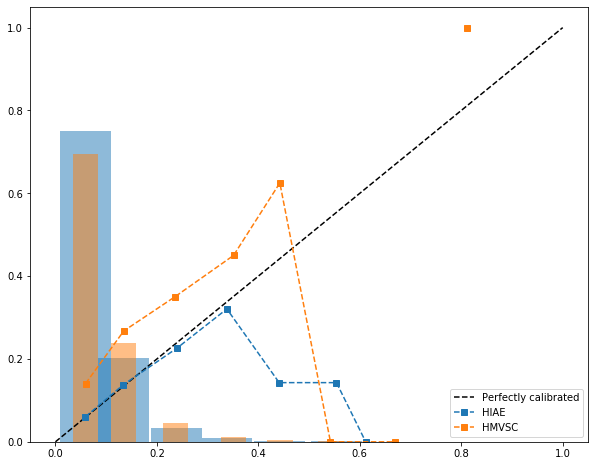

HIAE	AUC - 0.74 (0.72 - 0.76 95% CI)
HIAE	SMR - 1.00 (0.92 - 1.08 95% CI)
HMVSC	AUC - 0.78 (0.75 - 0.81 95% CI)
HMVSC	SMR - 1.99 (1.81 - 2.18 95% CI)


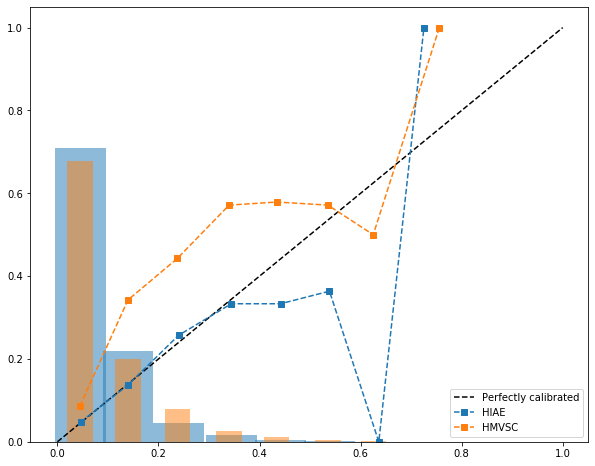

HIAE	AUC - 0.78 (0.76 - 0.80 95% CI)
HIAE	SMR - 1.00 (0.92 - 1.08 95% CI)
HMVSC	AUC - 0.74 (0.71 - 0.77 95% CI)
HMVSC	SMR - 2.51 (2.28 - 2.77 95% CI)


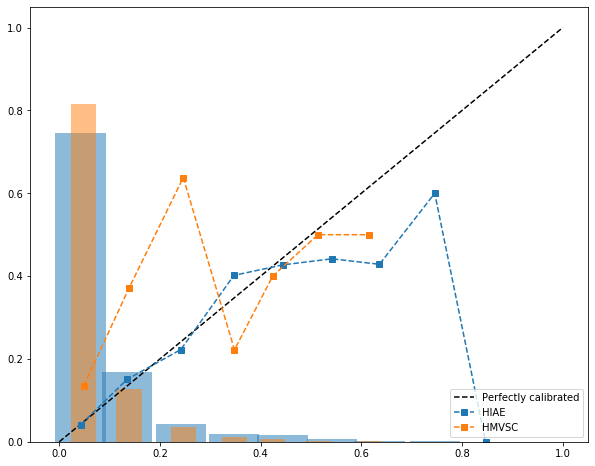

HIAE	AUC - 0.81 (0.79 - 0.82 95% CI)
HIAE	SMR - 1.00 (0.92 - 1.08 95% CI)
HMVSC	AUC - 0.77 (0.74 - 0.80 95% CI)
HMVSC	SMR - 2.37 (2.15 - 2.59 95% CI)


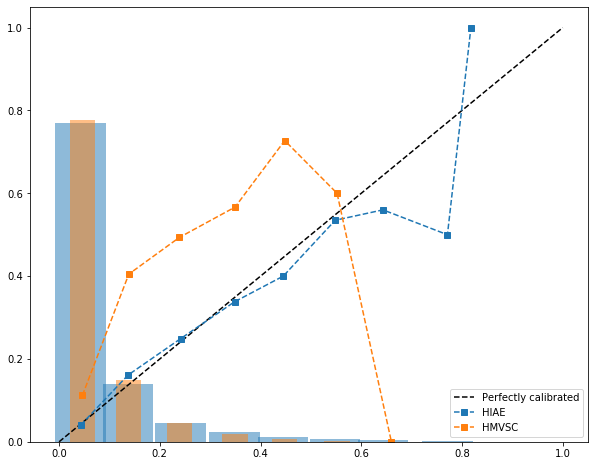

HIAE	AUC - 0.84 (0.82 - 0.85 95% CI)
HIAE	SMR - 1.00 (0.93 - 1.08 95% CI)
HMVSC	AUC - 0.83 (0.80 - 0.85 95% CI)
HMVSC	SMR - 2.11 (1.93 - 2.30 95% CI)


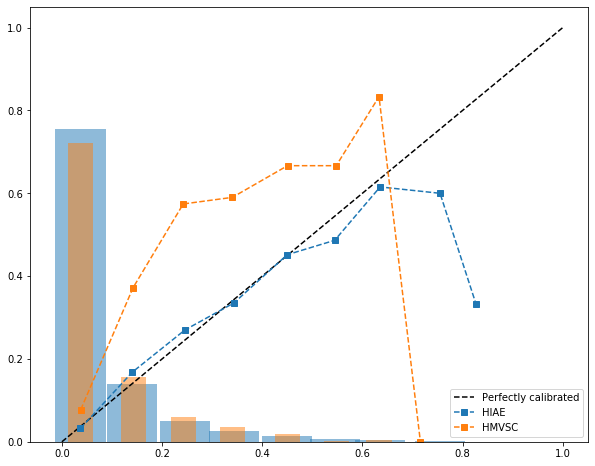

In [34]:
'''Run the model on each of the four blocks'''
for block in range(1,6):
    # prepare data
    X_hiae, y_hiae, X_hmvsc, y_hmvsc, _, c_cols, _, c_vals = prep_data(
        hiae.copy(), hmvsc.copy(), columns2block(block), target, model='xgb')
    
    # Model
    xbst = XGBClassifier(n_estimators=100, max_depth=2)
    
    # Create pipeline
    pipe = Pipeline([
        ("transformer", ColumnTransformer([
            ("oenc", OrdinalEncoder(c_vals), c_cols),
        ], remainder="passthrough")),
        ("model", xbst)
    ])
    
    #== train model on hiae
    model = pipe.fit(X_hiae, y_hiae)
    
    #== make predictions
    y_true_hmvsc = np.array(y_hmvsc)
    y_pred_hmvsc = model.predict_proba(X_hmvsc)[:,1]
    
    # also get cross-validation performance on hiae
    y_true_hiae = np.array(y_hiae)
    y_pred_hiae = cross_val_predict(pipe, X_hiae, y_hiae, cv=10, method='predict_proba')[:,1]
    
    # plot performance
    plt.figure(figsize=[10,8])
    ax = plt.gca()
    ax.plot([0,1],[0,1], linestyle='--', color='k', label="Perfectly calibrated")
    plot_calib_curve(y_true_hiae, y_pred_hiae, ax=ax,
                     with_histogram=True, width=0.1,
                     marker="s", linestyle='--', label="HIAE")
    plot_calib_curve(y_true_hmvsc, y_pred_hmvsc, ax=ax,
                     with_histogram=True, width=0.05,
                     marker="s", linestyle='--', label="HMVSC")
    
    plt.legend(loc='lower right')
    plt.show()

## XGBoost trained in HIAE imputed data

HIAE	AUC - 0.67 (0.64 - 0.69 95% CI)
HIAE	SMR - 1.01 (0.92 - 1.09 95% CI)
HMVSC	AUC - 0.65 (0.61 - 0.68 95% CI)
HMVSC	SMR - 2.07 (1.88 - 2.28 95% CI)


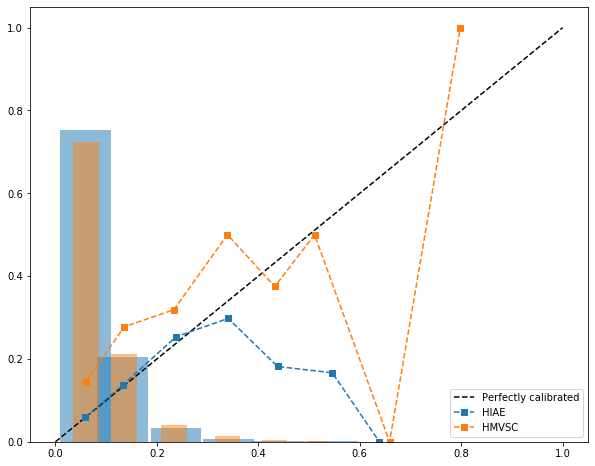

HIAE	AUC - 0.74 (0.72 - 0.77 95% CI)
HIAE	SMR - 1.00 (0.93 - 1.08 95% CI)
HMVSC	AUC - 0.78 (0.75 - 0.80 95% CI)
HMVSC	SMR - 2.06 (1.87 - 2.25 95% CI)


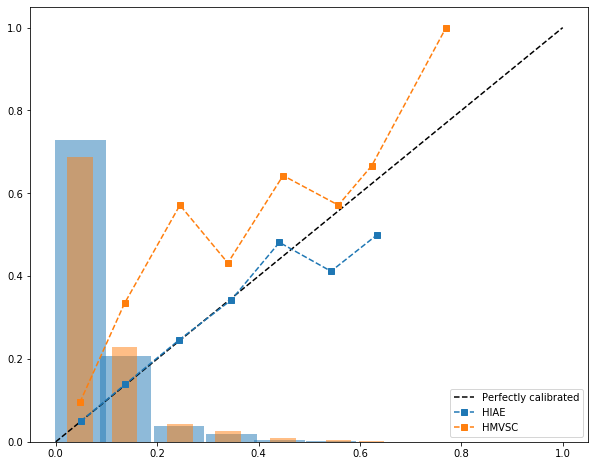

HIAE	AUC - 0.78 (0.76 - 0.80 95% CI)
HIAE	SMR - 1.00 (0.93 - 1.08 95% CI)
HMVSC	AUC - 0.75 (0.71 - 0.77 95% CI)
HMVSC	SMR - 2.54 (2.30 - 2.78 95% CI)


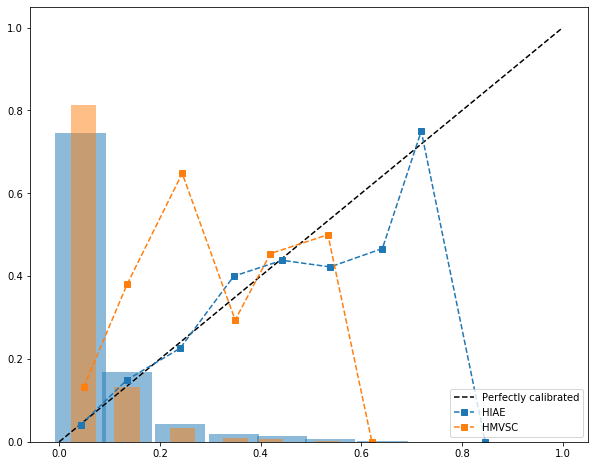

HIAE	AUC - 0.81 (0.79 - 0.83 95% CI)
HIAE	SMR - 1.00 (0.93 - 1.08 95% CI)
HMVSC	AUC - 0.76 (0.73 - 0.79 95% CI)
HMVSC	SMR - 2.50 (2.27 - 2.72 95% CI)


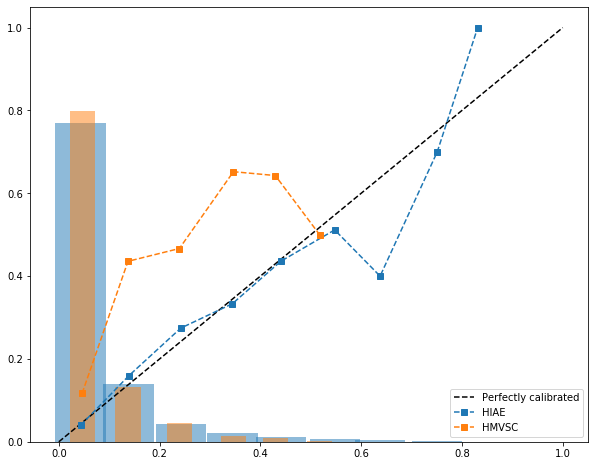

HIAE	AUC - 0.84 (0.82 - 0.85 95% CI)
HIAE	SMR - 1.01 (0.94 - 1.08 95% CI)
HMVSC	AUC - 0.83 (0.80 - 0.85 95% CI)
HMVSC	SMR - 2.28 (2.08 - 2.49 95% CI)


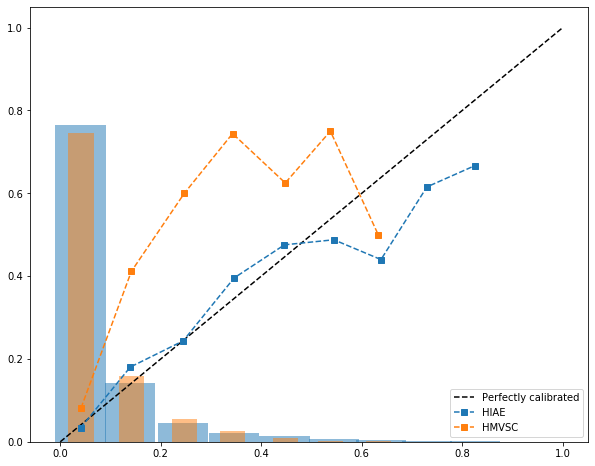

In [35]:
'''Run the model on each of the four blocks'''
for block in range(1,6):
    # prepare data
    X_hiae, y_hiae, X_hmvsc, y_hmvsc, filtered_normal, c_cols, _, c_vals = prep_data(
        hiae.copy(), hmvsc.copy(), columns2block(block), target, model='xgbi')
    
    # Model
    xgbi = XGBClassifier(n_estimators=100, max_depth=2)
    
    # Create pipeline
    pipe = Pipeline([
        ("imputer", Imputer(filtered_normal, c_cols)),
        ("transformer", ColumnTransformer([
            ("oenc", OrdinalEncoder(c_vals), c_cols)
        ], remainder="passthrough")),
        ("model", xgbi)
    ])
    
    #== train model on hiae
    model = pipe.fit(X_hiae, y_hiae)
    
    #== make predictions
    y_true_hmvsc = np.array(y_hmvsc)
    y_pred_hmvsc = model.predict_proba(X_hmvsc)[:,1]
    
    # also get cross-validation performance on hiae
    y_true_hiae = np.array(y_hiae)
    y_pred_hiae = cross_val_predict(pipe, X_hiae, y_hiae, cv=10, method='predict_proba')[:,1]
    
    # plot performance
    plt.figure(figsize=[10,8])
    ax = plt.gca()
    ax.plot([0,1],[0,1], linestyle='--', color='k', label="Perfectly calibrated")
    plot_calib_curve(y_true_hiae, y_pred_hiae, ax=ax,
                     with_histogram=True, width=0.1,
                     marker="s", linestyle='--', label="HIAE")
    plot_calib_curve(y_true_hmvsc, y_pred_hmvsc, ax=ax,
                     with_histogram=True, width=0.05,
                     marker="s", linestyle='--', label="HMVSC")
    
    plt.legend(loc='lower right')
    plt.show()

## SEVERITAS

#### Feature selection

In [36]:
''' Feature Selection '''

# prepare data
X_hiae, y_hiae, X_hmvsc, y_hmvsc, filtered_normal, c_cols, n_cols, c_vals = prep_data(
    hiae.copy(), hmvsc.copy(), columns2block(5), target, model='logr')
columns = [c for c in X_hiae.columns if c not in c_cols+n_cols]

# Create pipeline
pipe = Pipeline([
    ("imputer", Imputer(filtered_normal, c_cols)),
    ("transformer", ColumnTransformer([
        ("ohe", OneHotEncoder(categories=c_vals), c_cols),
        ("scaler", StandardScaler(), n_cols)
    ], remainder="passthrough")),
])

# Transform data
X_hiae = pipe.fit_transform(X_hiae, y_hiae)
    
# Calculates auc for each c-value
auc_values = np.array([])
cs = np.linspace(0.01,1,100)
for C in cs:
    # Model
    logr = LogisticRegression(solver='liblinear', penalty='l1', C=C)
    
    # also get cross-validation performance on hiae
    y_true_hiae = np.array(y_hiae)
    y_pred_hiae = cross_val_predict(logr, X_hiae, y_hiae, cv=10, method='predict_proba')[:,1]
    
    # Appends result to array
    auc_values = np.append(auc_values, roc_auc_score(y_true_hiae, y_pred_hiae))

# Find C-value one stardard deviation away from best performing auc
std = np.std(auc_values)
mmo = np.max(auc_values) - std
print("Best C-value:")
print(cs[np.argmax(auc_values)])
for a, c in zip(auc_values, cs):
    if a >= mmo:
        C = c
        break

# Model
logr = LogisticRegression(solver='liblinear', penalty='l1', C=C)
logr.fit(X_hiae, y_hiae)

# Get coefficients
coef_dict = {"Variable": [], "Coefficient": []}
print("-----COEFFICIENTS-----")
cat = [c_cols[i] + " - " + str(c) for i, ca in enumerate(c_vals) for c in ca]
columns = cat+n_cols+columns
coef = logr.coef_[0]
for i in range(X_hiae.shape[1]):
    coef_dict["Variable"].append(columns[i])
    coef_dict["Coefficient"].append(round(coef[i],2))
display(pd.DataFrame(coef_dict))
print("-----------------------\n")

Best C-value:
0.25
-----COEFFICIENTS-----


,Variable,Coefficient
0,genders - 0.0,0.00
1,genders - 1.0,0.00
2,admissionsourcename - emergency room,-0.48
3,admissionsourcename - floor,0.00
4,admissionsourcename - operating room,-0.77
5,admissionsourcename - other icu,0.00
6,admissionsourcename - other sources,0.00
7,admissiontypename - Cirurgia de urgência / eme...,0.00
8,admissiontypename - Cirurgia eletiva,-0.43
9,admissiontypename - Clínica,0.00


-----------------------



#### Remove features and calibrate on HMVSC

HIAE	AUC - 0.83 (0.81 - 0.84 95% CI)
HIAE	SMR - 1.00 (0.92 - 1.08 95% CI)
HMVSC	AUC - 0.84 (0.82 - 0.86 95% CI)
HMVSC	SMR - 1.97 (1.81 - 2.15 95% CI)


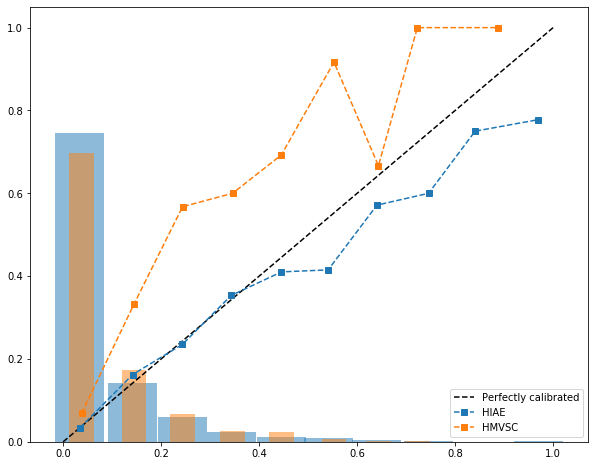

-----COEFFICIENTS-----


,Variable,Coefficient
0,admissionsourcename - emergency room,-0.72
1,admissionsourcename - floor,0.00
2,admissionsourcename - operating room,-0.98
3,admissionsourcename - other icu,0.31
4,admissionsourcename - other sources,0.02
5,admissiontypename - Cirurgia de urgência / eme...,0.00
6,admissiontypename - Cirurgia eletiva,-0.76
7,admissiontypename - Clínica,0.11
8,chronic_health_status_name - Independente,-0.35
9,chronic_health_status_name - Necessidade de As...,-0.19


-----------------------

HIAE	AUC - 0.84 (0.82 - 0.85 95% CI)
HIAE	SMR - 0.51 (0.48 - 0.55 95% CI)
HMVSC	AUC - 0.84 (0.82 - 0.86 95% CI)
HMVSC	SMR - 1.00 (0.92 - 1.08 95% CI)


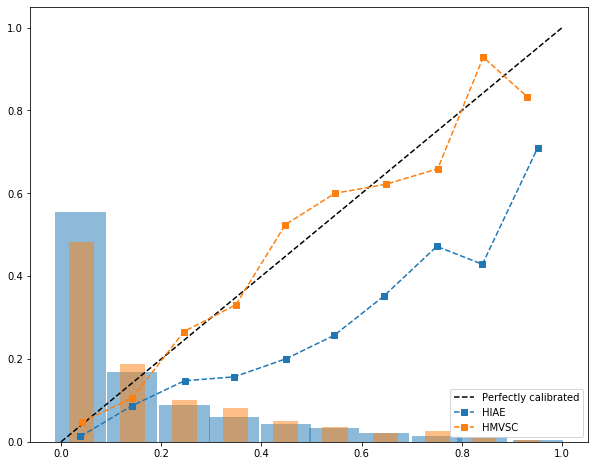

In [37]:
''' Remove features and recalibrate '''

# Remove columns excluded from feature selection
drop = ["lowest_mean_arterial_pressure1h", "lowest_diastolic_blood_pressure1h",
        "genders", "bmi_group"]
columns = columns2block(5)
columns = [c for c in columns if c not in drop]

# prepare data
X_hiae, y_hiae, X_hmvsc, y_hmvsc, filtered_normal, c_cols, n_cols, c_vals = prep_data(
    hiae.copy(), hmvsc.copy(), columns, target, model='logr') 
columns = [c for c in X_hiae.columns if c not in c_cols+n_cols]

# Create pipeline
pipe = Pipeline([
    ("imputer", Imputer(filtered_normal, c_cols)),
    ("transformer", ColumnTransformer([
        ("ohe", OneHotEncoder(categories=c_vals), c_cols),
        ("scaler", StandardScaler(), n_cols)
    ], remainder="passthrough"))
])

# Transform data
X_hiae = pipe.fit_transform(X_hiae, y_hiae)

# Model
logr = LogisticRegression(solver='liblinear', penalty='l1')
model = logr.fit(X_hiae, y_hiae)

# transform hmvsc data
X_hmvsc = pipe.transform(X_hmvsc)

#== make predictions
y_true_hmvsc = np.array(y_hmvsc)
y_pred_hmvsc = model.predict_proba(X_hmvsc)[:,1]

# also get cross-validation performance on hiae
y_true_hiae = np.array(y_hiae)
y_pred_hiae = cross_val_predict(logr, X_hiae, y_hiae, cv=10, method='predict_proba')[:,1]

# plot performance
plt.figure(figsize=[10,8])
ax = plt.gca()
ax.plot([0,1],[0,1], linestyle='--', color='k', label="Perfectly calibrated")
plot_calib_curve(y_true_hiae, y_pred_hiae, ax=ax,
                 with_histogram=True, width=0.1,
                 marker="s", linestyle='--', label="HIAE")
plot_calib_curve(y_true_hmvsc, y_pred_hmvsc, ax=ax,
                 with_histogram=True, width=0.05,
                 marker="s", linestyle='--', label="HMVSC")

plt.legend(loc='lower right')
plt.show()

# recalibrate model
model = CalibratedClassifierCV(model, cv='prefit')
model = model.fit(X_hmvsc, y_hmvsc)

#== make predictions
severitas_hmvsc = y_true_hmvsc = np.array(y_hmvsc)
severitas_hmvsc = y_pred_hmvsc = model.predict_proba(X_hmvsc)[:,1]

# also get cross-validation performance on hiae
y_true_hiae = np.array(y_hiae)
y_pred_hiae = model.predict_proba(X_hiae)[:,1]

# Get coefficients
coef_dict = {"Variable": [], "Coefficient": []}
print("-----COEFFICIENTS-----")
cat = [c_cols[i] + " - " + str(c) for i, ca in enumerate(c_vals) for c in ca]
columns = cat+n_cols+columns
coef = logr.coef_[0]
for i in range(X_hiae.shape[1]):
    coef_dict["Variable"].append(columns[i])
    coef_dict["Coefficient"].append(round(coef[i],2))
display(pd.DataFrame(coef_dict))
print("-----------------------\n")

# plot performance
plt.figure(figsize=[10,8])
ax = plt.gca()
ax.plot([0,1],[0,1], linestyle='--', color='k', label="Perfectly calibrated")
plot_calib_curve(y_true_hiae, y_pred_hiae, ax=ax,
                 with_histogram=True, width=0.1,
                 marker="s", linestyle='--', label="HIAE")
plot_calib_curve(y_true_hmvsc, y_pred_hmvsc, ax=ax,
                 with_histogram=True, width=0.05,
                 marker="s", linestyle='--', label="HMVSC")

plt.legend(loc='lower right')
plt.show()

## Plot AUROCs (TropICS, R-MPM, SAPS3 and SEVERITAS)

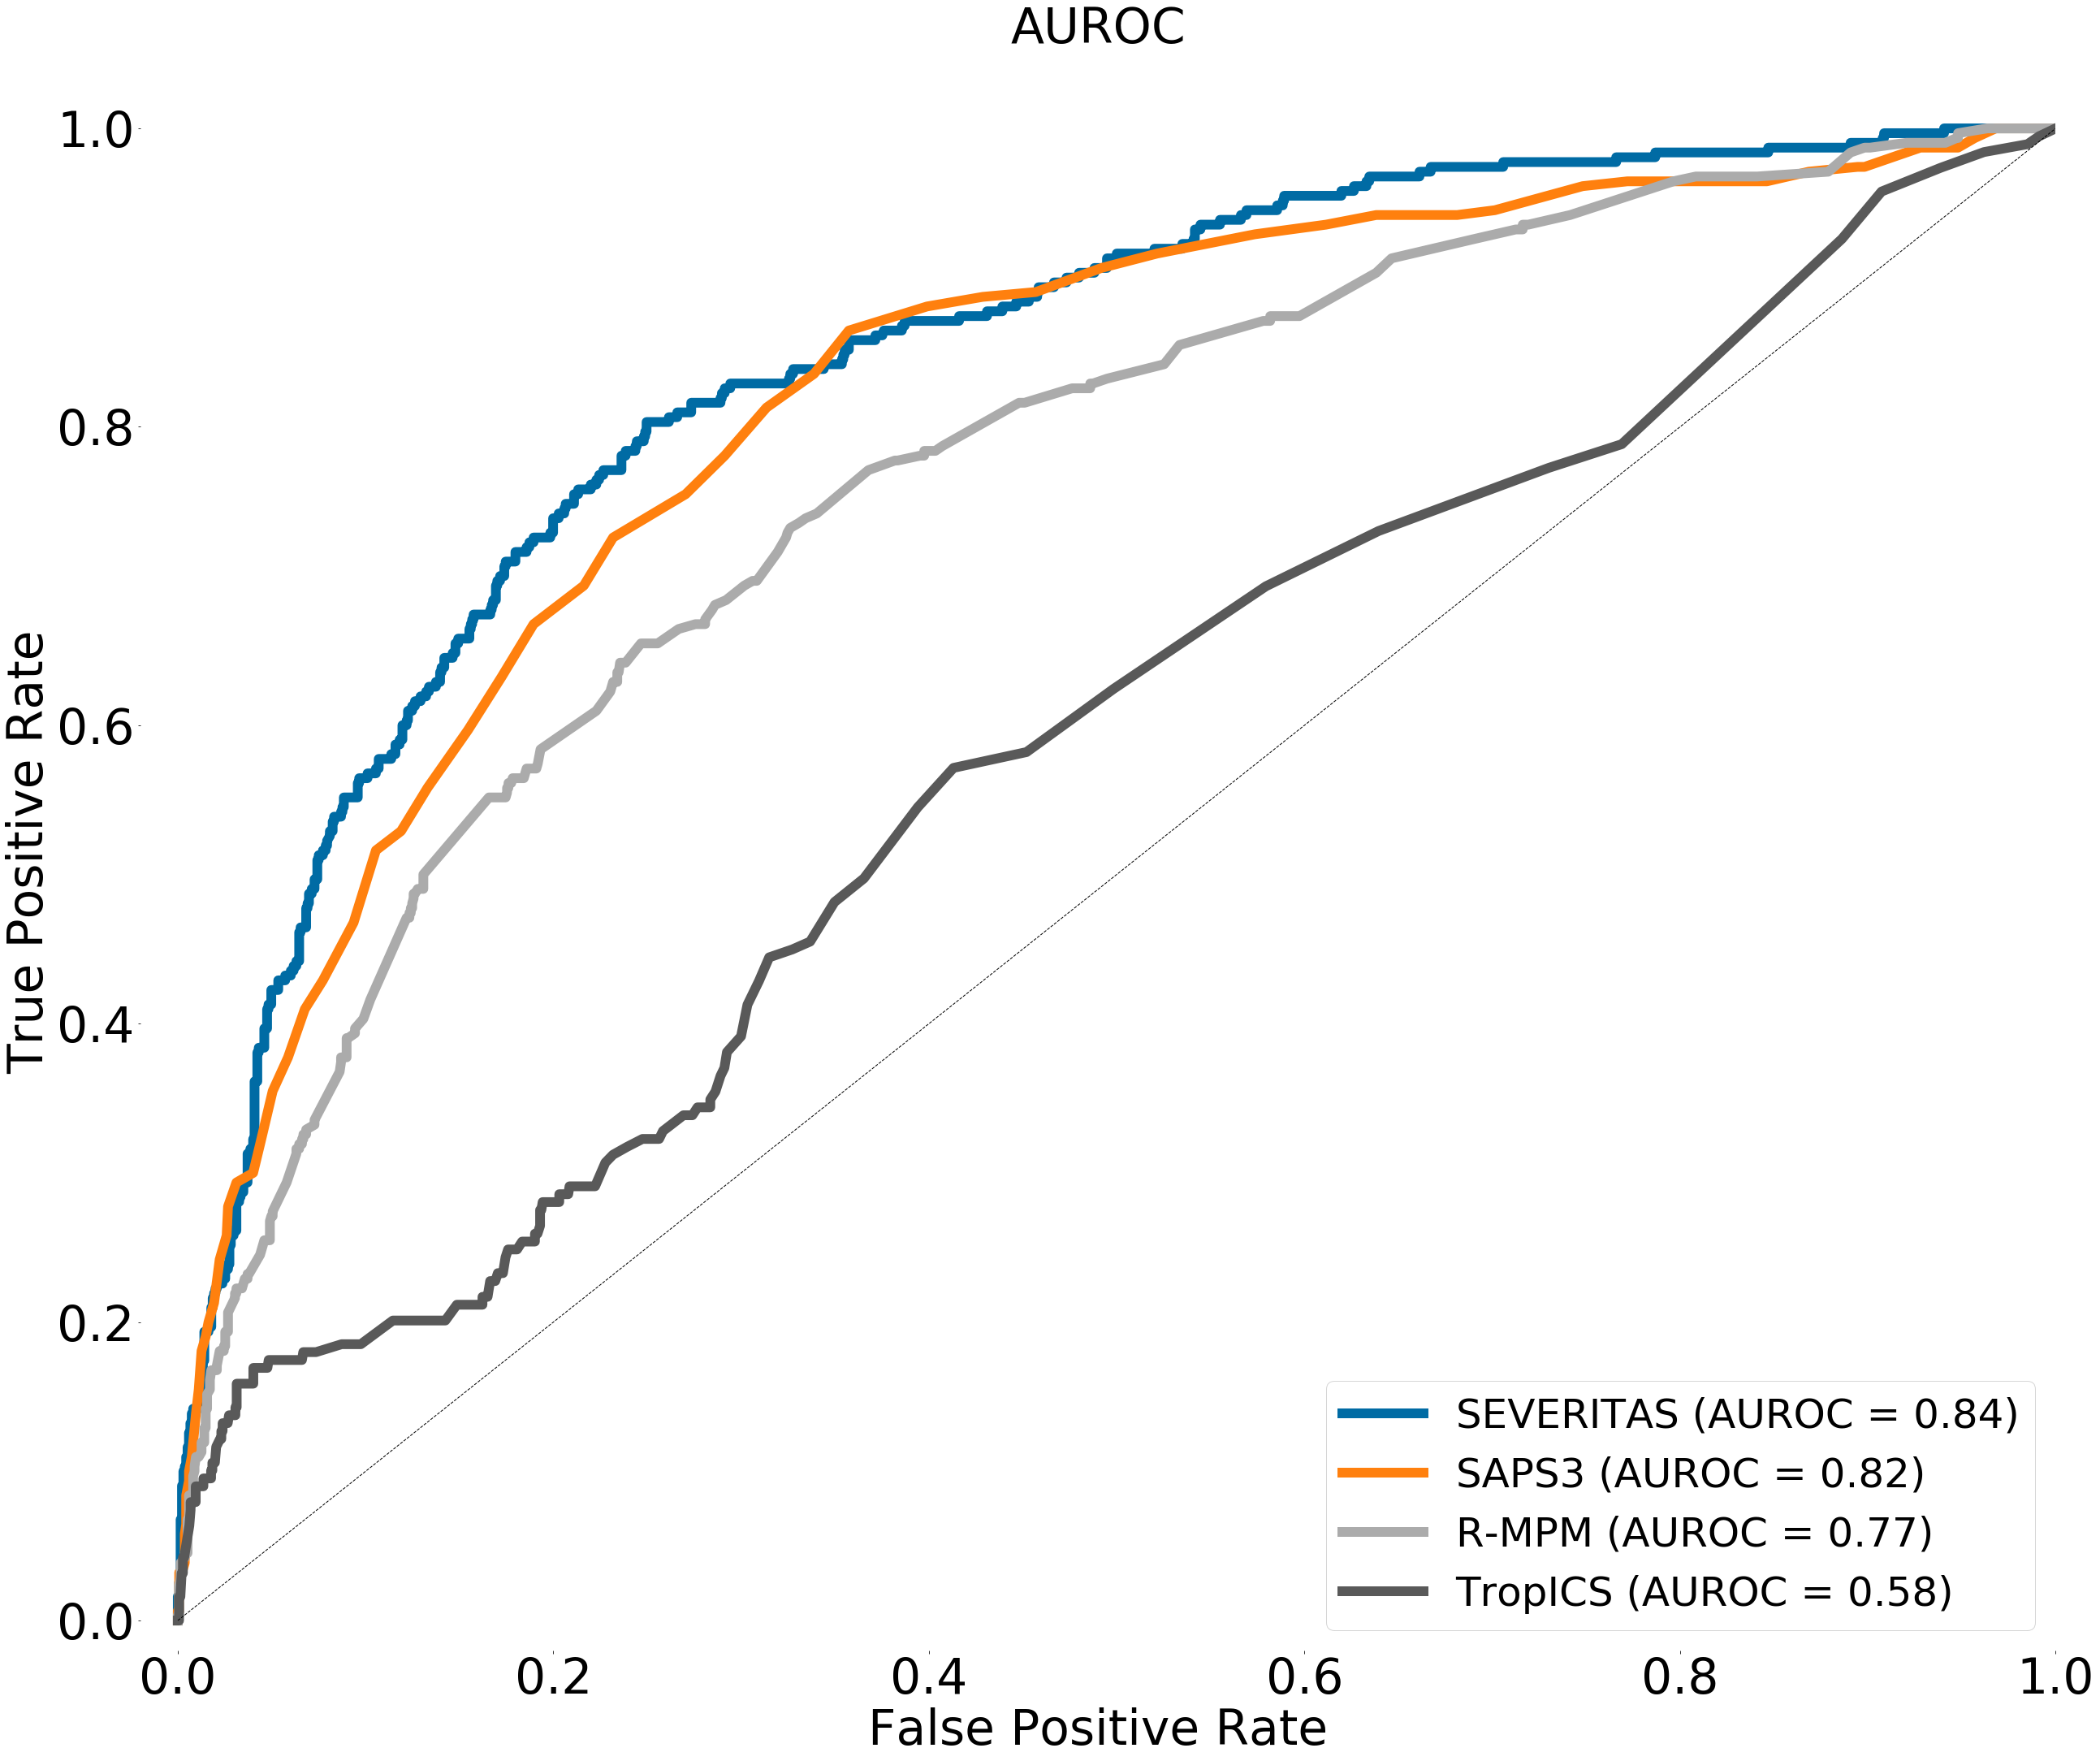

In [38]:
fig, ax = plt.subplots(figsize=(36, 30))
fig.tight_layout()
ax.tick_params(labelsize=60)
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)

lw = 12
preds = [severitas_hmvsc, hmvsc.saps_prob, rmpm_hmvsc.rmpm, tropics_hmvsc.tropics]
trues = [hmvsc[target], hmvsc[target], hmvsc[target], hmvsc.unitdischargecode]
colors = ["#006ba4", "#ff800e", "#ababab", "#595959"]
labels = ["SEVERITAS", "SAPS3", "R-MPM", "TropICS"]
lst = []
for i in range(len(preds)):
    fpr, tpr, _ = roc_curve(trues[i], preds[i])
    auc_plt = ax.plot(fpr, tpr, color=colors[i], lw=lw)[0]
    lst.append(auc_plt)
    labels[i] = '{0} (AUROC = {1:0.2f})'.format(labels[i], auc(fpr, tpr))
    
ax.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
ax.set_xlim([-0.02, 1.0])
ax.set_ylim([-0.02, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=60)
ax.set_ylabel('True Positive Rate', fontsize=60)
ax.legend(lst, labels, fontsize=50, loc=4)
ax.set_title('AUROC', fontsize=60)
plt.gcf().subplots_adjust(top=0.97, bottom=0.06, left=0.07, right=0.98)
fig.savefig("figure2_aurocs.png")